To test the statevector permutation problem
using AER toy example

In [1]:
# Standard libraries
import numpy as np
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# Point to the *parent* of the package folder
LOCAL_QG_PATH = r"..\src"   # or r"C:\path\to\your\local\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# Invalidate import caches and import the local package
importlib.invalidate_caches()
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit, Circuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import RotatedSurfaceCode
from quantum_gates.utilities import SurfaceCode



Using quantum_gates from: c:\Users\npace\Desktop\quantum-gates\src\quantum_gates\__init__.py


Stabilizer (2, 4) (X) measures data qubits: []
Stabilizer (2, 6) (X) measures data qubits: []
Stabilizer (4, 10) (X) measures data qubits: []
Stabilizer (4, 12) (X) measures data qubits: []
Stabilizer (0, 0) (Z) measures data qubits: []
Stabilizer (2, 5) (Z) measures data qubits: []
Stabilizer (4, 11) (Z) measures data qubits: []
Stabilizer (6, 16) (Z) measures data qubits: []
Parity-check matrix for X stabilizers built.
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
Parity-check matrix for Z stabilizers built.
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
Decoder setup complete.


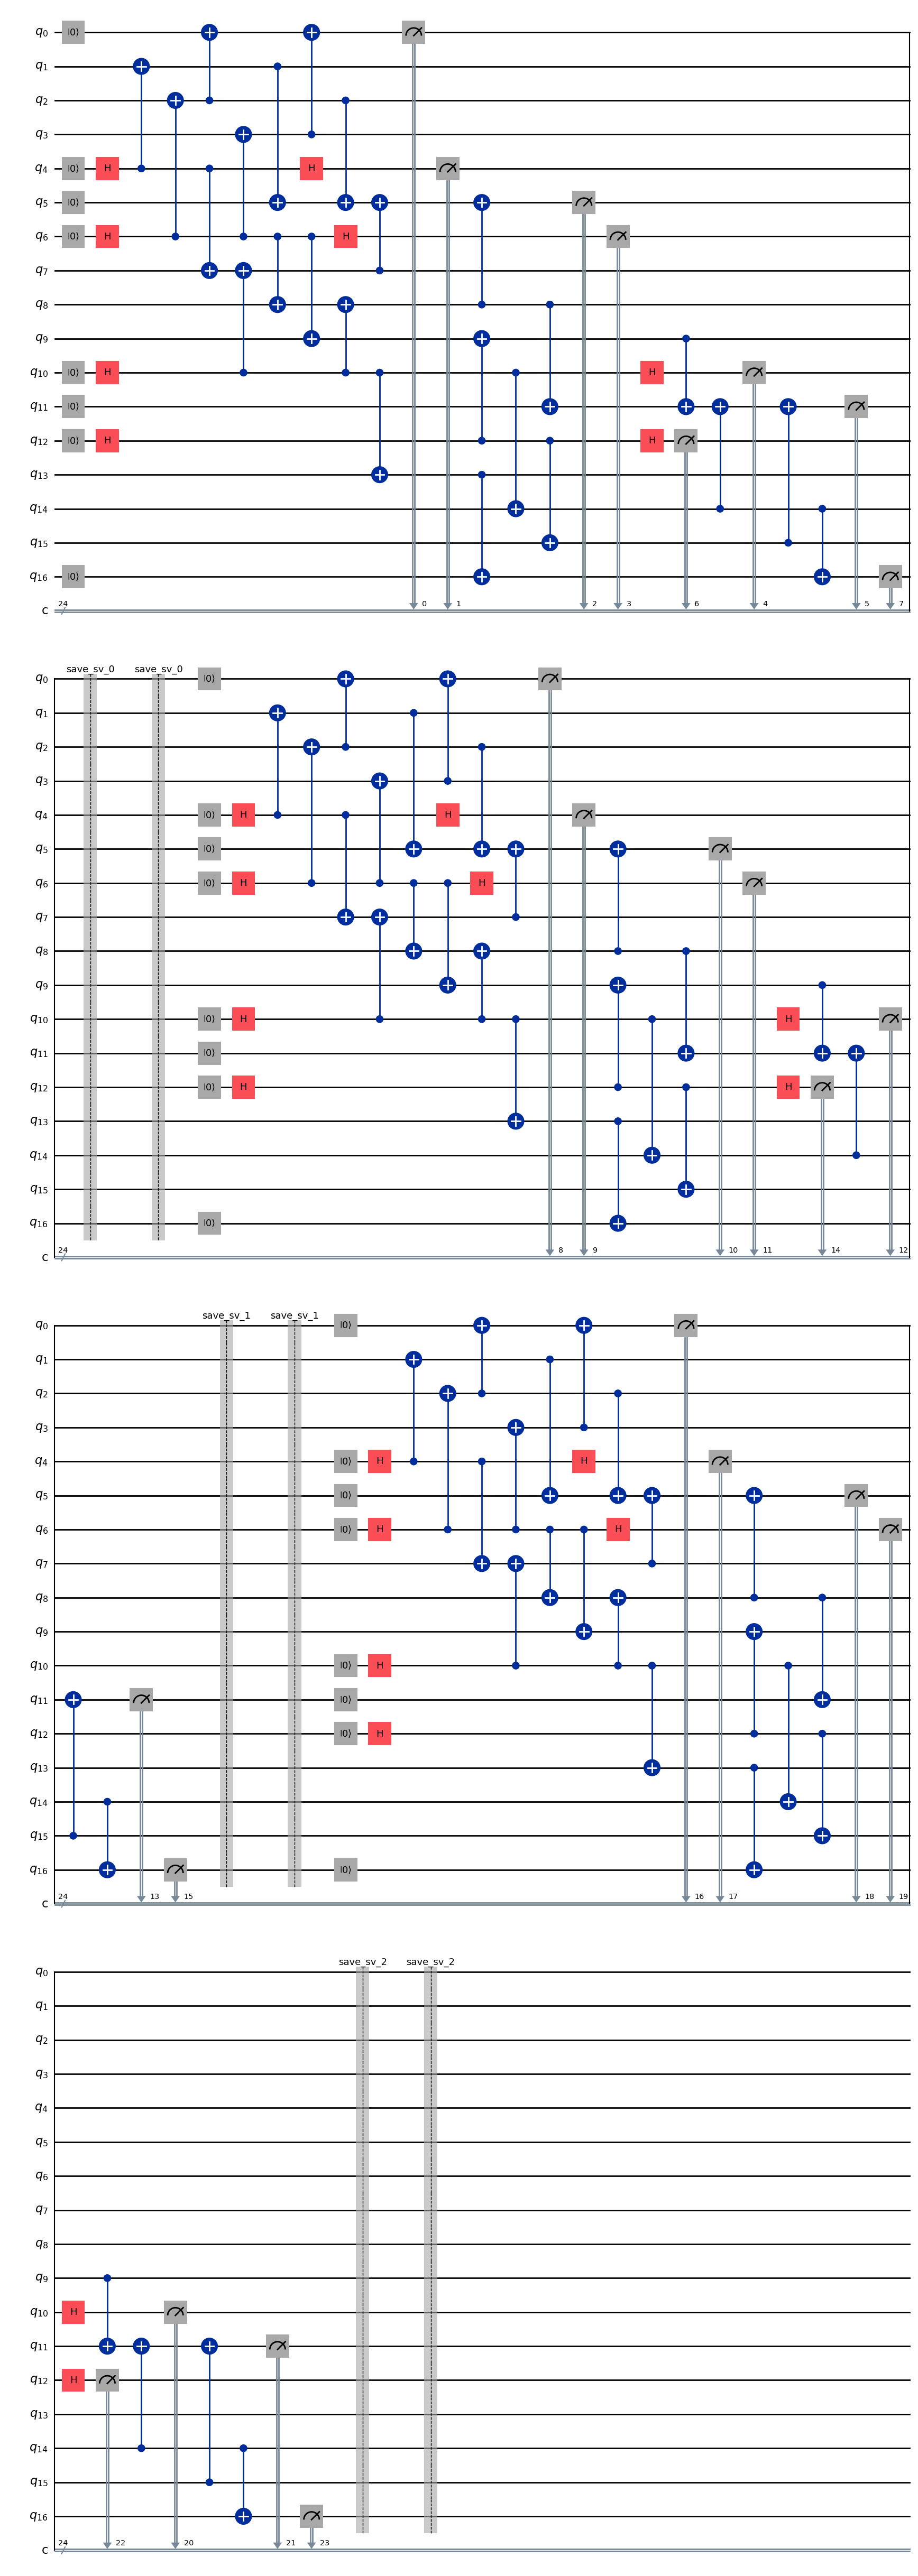

In [ ]:

cycles=3
distance = 3

# build a Rotated Surface Code Circuit
code = RotatedSurfaceCode(distance=distance, cycles=cycles)
qc = code.qc

qc.draw('mpl')

Might need the device parameters to transpile

In [3]:
# Simulate with Aer
shots = 1
sim = AerSimulator(method="statevector")
result_orig = sim.run(qc, shots=shots).result()

orig_svs = {}
for label in result_orig.data().keys():
    orig_svs[label] = result_orig.data()[label]

counts = result_orig.get_counts()

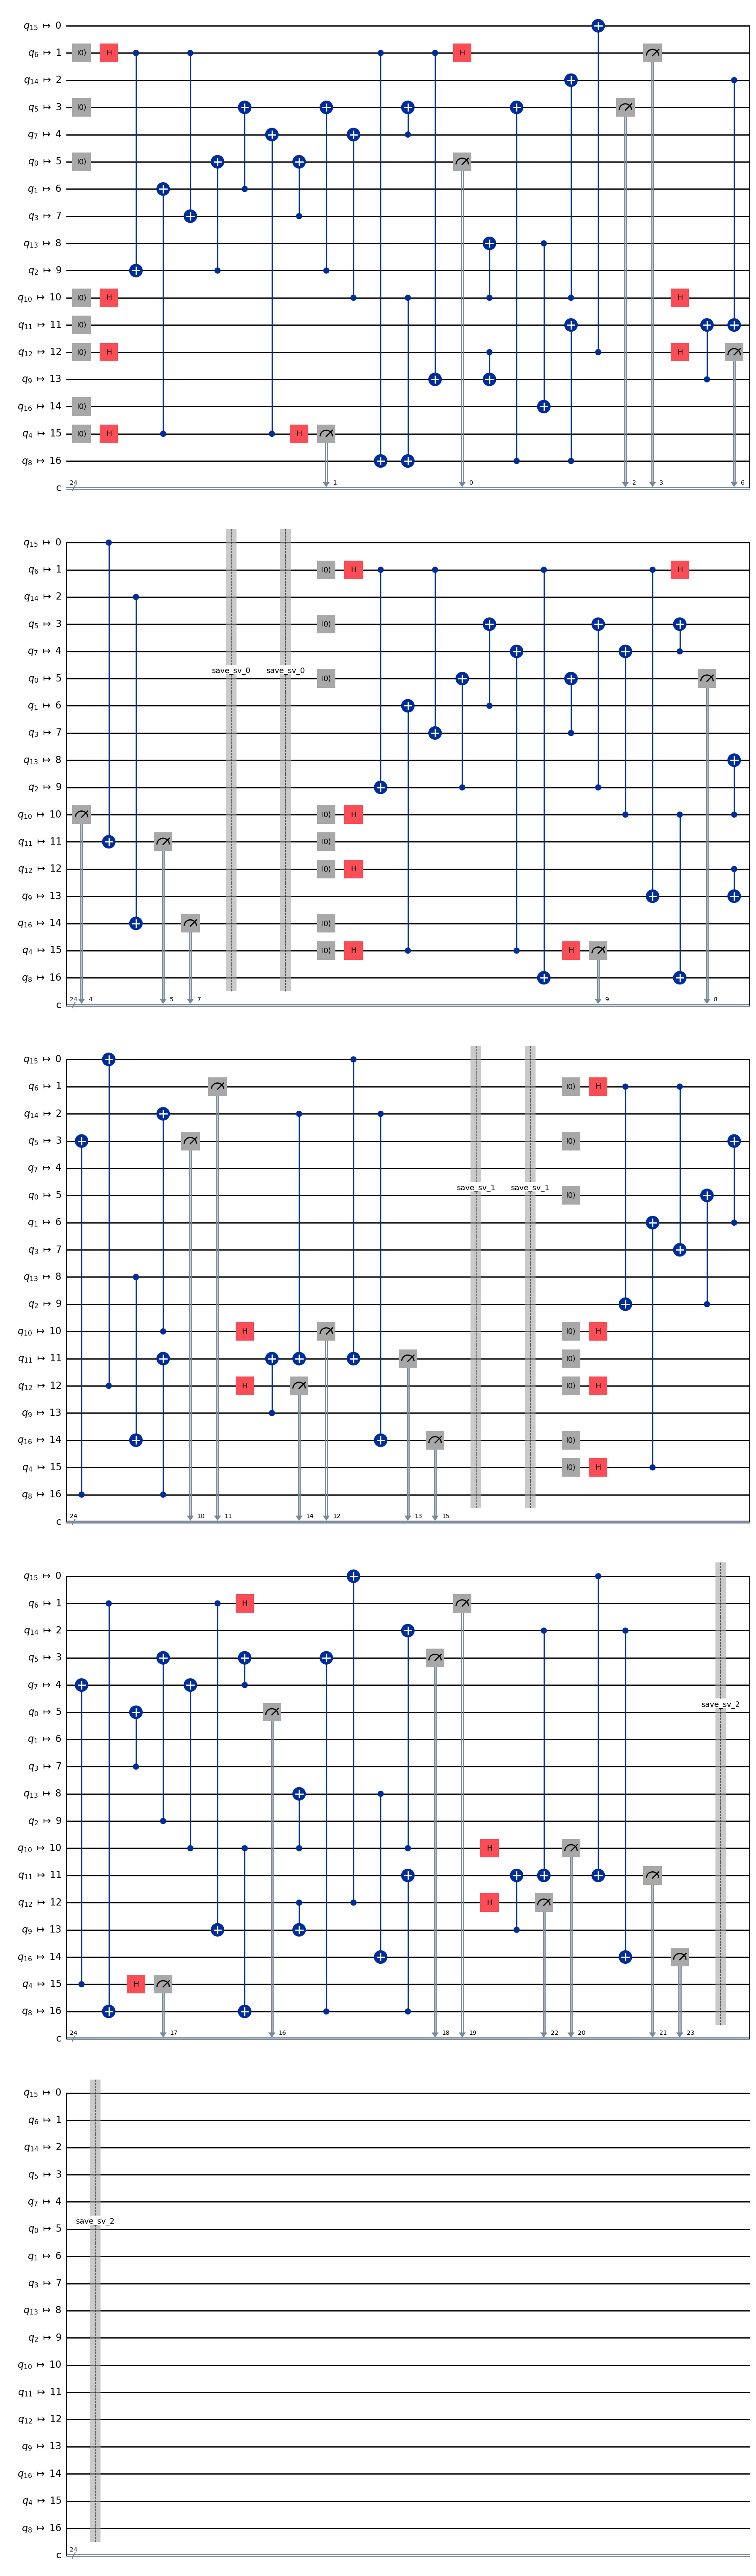

In [4]:
num_q = qc.num_qubits
cm = CouplingMap.from_full(num_q)

transpiled_circ = transpile(qc, coupling_map=cm, optimization_level=2)
#transpiled_circ = transpile(qc, coupling_map=[[0,1],[1,0],[1,2],[2,1]], optimization_level=2)
transpiled_circ.draw('mpl')

In [5]:
result_trans = sim.run(transpiled_circ, shots=shots).result()

trans_svs = {}
for label in result_trans.data().keys():
    trans_svs[label] = result_trans.data()[label]

counts_trans = result_trans.get_counts()

In [6]:

def sv_only(d):
    """Return dictionary filtered to contain only actual Statevector entries."""
    return {label: sv for label, sv in d.items() if isinstance(sv, Statevector)}

orig_svs_clean = sv_only(orig_svs)
trans_svs_clean = sv_only(trans_svs)


In [7]:
print('-- Before Permutation Statevector Results --')
for label in trans_svs_clean:
    print(label)
    print('Original Circuit: ', np.array(orig_svs_clean[label]))
    print('Transpilled Circuit: ',np.array(trans_svs_clean[label]))
    F = state_fidelity(orig_svs_clean[label], trans_svs_clean[label])
    print("** Fidelity ", F, "\n")


-- Before Permutation Statevector Results --
save_sv_0
Original Circuit:  [0.25+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
Transpilled Circuit:  [0.25+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
** Fidelity  0.00390625 

save_sv_1
Original Circuit:  [0.25-1.2246468e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
Transpilled Circuit:  [0.25-1.2246468e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
** Fidelity  0.00390625 

save_sv_2
Original Circuit:  [0.25-1.8369702e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
Transpilled Circuit:  [0.25-1.8369702e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
** Fidelity  0.00390625 



Permutation Work   

In [8]:
def extract_save_qubit_orders(transpiled):
    """
    Return list of (label, qubit_order_list)
    where qubit_order_list gives the physical qubits used
    by that SaveStatevector instruction at that moment.
    """
    save_info = []

    for inst, qargs, cargs in transpiled.data:
        if inst.name == "save_statevector":
            label = inst.label  # read label string
            qubit_order = [transpiled.find_bit(q).index for q in qargs]
            save_info.append((label, qubit_order))

    return save_info

In [9]:
def extract_barrier_qubit_orders(transpiled):
    """
    Return list of (label, qubit_order_list)
    where qubit_order_list gives the physical qubits used
    by that SaveStatevector instruction at that moment.
    """
    save_info = []

    for inst, qargs, cargs in transpiled.data:
        if inst.name == "barrier":
            label = inst.label  # read label string
            if label is not None and "save" in label:
                qubit_order = [transpiled.find_bit(q).index for q in qargs]
                save_info.append((label, qubit_order))

    return save_info

In [10]:
print('-- Statevector Orders -- ')
trans_save_info = extract_save_qubit_orders(transpiled_circ)
print(trans_save_info, '\n')

print('-- Barrier Orders -- ')
trans_save_info_barrier = extract_barrier_qubit_orders(transpiled_circ)
print(trans_save_info_barrier)



-- Statevector Orders -- 
[('save_sv_0', [5, 6, 9, 7, 15, 3, 1, 4, 16, 13, 10, 11, 12, 8, 2, 0, 14]), ('save_sv_1', [5, 6, 9, 7, 15, 3, 1, 4, 16, 13, 10, 11, 12, 8, 2, 0, 14]), ('save_sv_2', [5, 6, 9, 7, 15, 3, 1, 4, 16, 13, 10, 11, 12, 8, 2, 0, 14])] 

-- Barrier Orders -- 
[('save_sv_0', [5, 6, 9, 7, 15, 3, 1, 4, 16, 13, 10, 11, 12, 8, 2, 0, 14]), ('save_sv_1', [5, 6, 9, 7, 15, 3, 1, 4, 16, 13, 10, 11, 12, 8, 2, 0, 14]), ('save_sv_2', [5, 6, 9, 7, 15, 3, 1, 4, 16, 13, 10, 11, 12, 8, 2, 0, 14])]


C:\Users\npace\AppData\Local\Temp\ipykernel_26260\3070367269.py:9: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in transpiled.data:


In [11]:
def permute_sv(sv, qubit_order):
    """
    sv: numpy statevector (complex array)
    qubit_order: list where qubit_order[logical] = physical qubit index
                 in the ordering used by the save instruction

    This restores the statevector into logical [0,1,2,...] order.
    """
    n = len(qubit_order)
    new_sv = np.zeros_like(sv)

    for idx in range(len(sv)):
        # physical bits in the statevector as output by Aer
        phys_bits = [(idx >> i) & 1 for i in range(n)]

        # reorder into logical order
        log_bits = [ phys_bits[qubit_order[logical]] for logical in range(n) ]

        # compute new index in logical basis ordering
        new_idx = sum(log_bits[i] << i for i in range(n))

        new_sv[new_idx] = sv[idx]

    return new_sv


In [12]:

# --- permute each statevector correctly ---
trans_permuted_svs = {}

for label, qubit_order in trans_save_info_barrier:
    sv_raw = np.array(trans_svs[label])   # raw transpiled statevector
    sv_logical = permute_sv(sv_raw, qubit_order)
    trans_permuted_svs[label] = sv_logical
    

In [13]:
print('-- PERMUTED --')
for label in trans_permuted_svs:
    print(label)
    print('Original Circuit: ', np.array(orig_svs_clean[label]))
    print('Permuted Transpilled Circuit: ',trans_permuted_svs[label])
    F = state_fidelity(orig_svs_clean[label], trans_permuted_svs[label])
    print("** Fidelity ", F, "\n")



-- PERMUTED --
save_sv_0
Original Circuit:  [0.25+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
Permuted Transpilled Circuit:  [0.25+0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
** Fidelity  1.0 

save_sv_1
Original Circuit:  [0.25-1.2246468e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
Permuted Transpilled Circuit:  [0.25-1.2246468e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
** Fidelity  1.0 

save_sv_2
Original Circuit:  [0.25-1.8369702e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
Permuted Transpilled Circuit:  [0.25-1.8369702e-16j 0.  +0.0000000e+00j 0.  +0.0000000e+00j ...
 0.  +0.0000000e+00j 0.  +0.0000000e+00j 0.  +0.0000000e+00j]
** Fidelity  1.0 



Original Circ Aer All clbits counts: {'000000000000000000000000': 1}


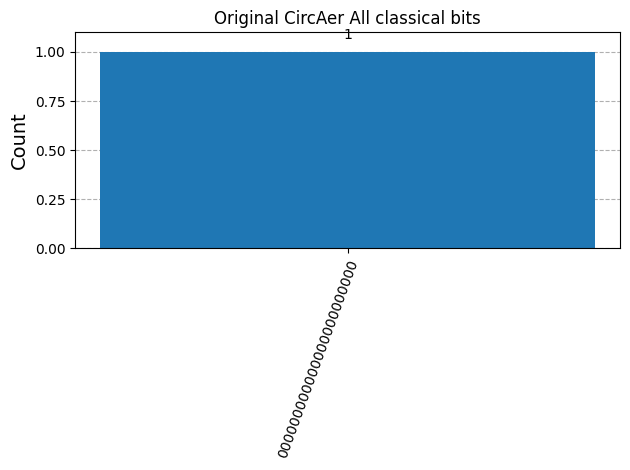

In [14]:
print("Original Circ Aer All clbits counts:", counts)
plot_histogram(counts, title="Original CircAer All classical bits")

Transpilled Circ Aer All clbits counts: {'000000000000000000000000': 1}


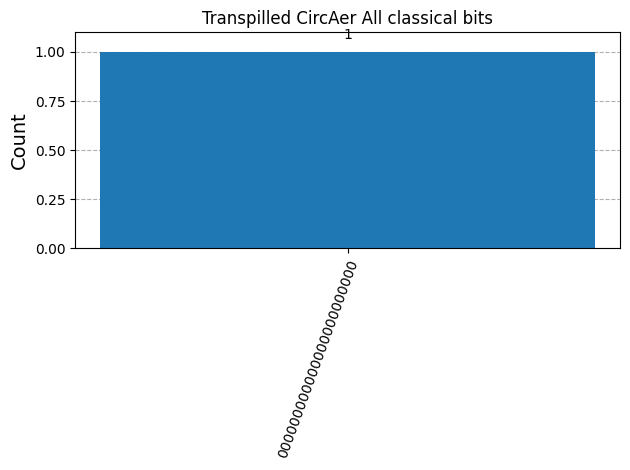

In [15]:
print("Transpilled Circ Aer All clbits counts:", counts_trans)
plot_histogram(counts_trans, title="Transpilled CircAer All classical bits")